In this notebook we will demonstrate the differences and possibilities in sampling. We will simulate a tree where one branch is much less dense than the others; this will showcase the difference when sampling the whole tree and when sampling according to the tree density. This difference is going to be excacerbated if we sample less densely, for instance by performing a pseudo-time series experiment.

In [1]:
import numpy as np
from numpy import random

# dimensionality reduction and visualization
import anndata as ad
from scanpy.tl import diffmap
from scanpy import pp
import matplotlib.pyplot as plt

# make sure to use viridis as the default color map
%matplotlib inline
import matplotlib as mpl

In [2]:
# import prosstt and its utilities
from prosstt import tree
from prosstt import simulation as sim
from prosstt import sim_utils as sut

import newick

In [3]:
# set random seed
rseed = 42
random.seed(rseed)

Simulate the tree:

In [4]:
newick_string = "(A:50,B:50)C:50;"
G = 500
lineage = tree.Tree.from_newick(newick_string, genes=G, modules=40)

uMs, Ws, Hs = sim.simulate_lineage(lineage)
gene_scale = sut.simulate_base_gene_exp(lineage, uMs)
lineage.add_genes(uMs, gene_scale)

/Users/papadopoulos/miniconda3/envs/scanpy/lib/python3.8/site-packages/prosstt/simulation.py:153: UserWarning: No argument 'a' specified in kwargs: using gamma and a=0.04
  warnings.warn(
/Users/papadopoulos/miniconda3/envs/scanpy/lib/python3.8/site-packages/scipy/stats/stats.py:3913: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


We will draw variance hyperparameters and use them for the duration of the experiment:

In [5]:
alpha1 = np.exp(random.normal(loc=np.log(0.2), scale=np.log(1.5), size=lineage.G))
beta1 = np.exp(random.normal(loc=np.log(1), scale=np.log(1.5), size=lineage.G)) + 1

Sample each position on the tree. This tree should be the "fullest", and its reconstruction pose the smallest problems.

In [6]:
X1, labs1, brns1, scalings1 = sim.sample_whole_tree(lineage, 1, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X1 = (X1.transpose() / scalings1).transpose()

Make branch A be much sparser:

In [7]:
tree_density = lineage.default_density()
density_offset = tree_density['C'][0] * 3/5
tree_density['A'] = tree_density['A'] - density_offset
tree_density['B'] = tree_density['B'] + density_offset # this means that B is denser than C, the "original" root
lineage.density = tree_density

Sample the density. We expect to have much more of branch "B" than branch "A", which should impact the quality of the reconstruction.

In [8]:
X2, labs2, brns2, scalings2 = sim.sample_density(lineage, 150, alpha=alpha1, beta=beta1)

# normalize gene expression by library size
X2 = (X2.transpose() / scalings2).transpose()

Sample via a pseudotime series. This makes the coverage of the tree more uneven, and the reconstruction harder.

In [9]:
X3, labs3, brns3, scalings3 = sim.sample_pseudotime_series(lineage, cells=150,
                                                           series_points=[10, 50, 90],
                                                           point_std=[2, 4, 2],
                                                           alpha=alpha1, beta=beta1)

X3 = (X3.transpose() / scalings3).transpose()

Calculate diffusion maps for all three simulated datasets and plot them:

In [10]:
data1 = ad.AnnData(np.log(X1+1))
pp.neighbors(data1, use_rep='X')
diffmap(adata=data1)
dm1 = data1.obsm["X_diffmap"]
br_names1, indices1 = np.unique(brns1, return_inverse=True)

data2 = ad.AnnData(np.log(X2+1))
pp.neighbors(data2, use_rep='X')
diffmap(adata=data2)
dm2 = data2.obsm["X_diffmap"]
br_names2, indices2 = np.unique(brns2, return_inverse=True)

data3 = ad.AnnData(np.log(X3+1))
pp.neighbors(data3, use_rep='X')
diffmap(adata=data3)
dm3 = data3.obsm["X_diffmap"]
br_names3, indices3 = np.unique(brns3, return_inverse=True)

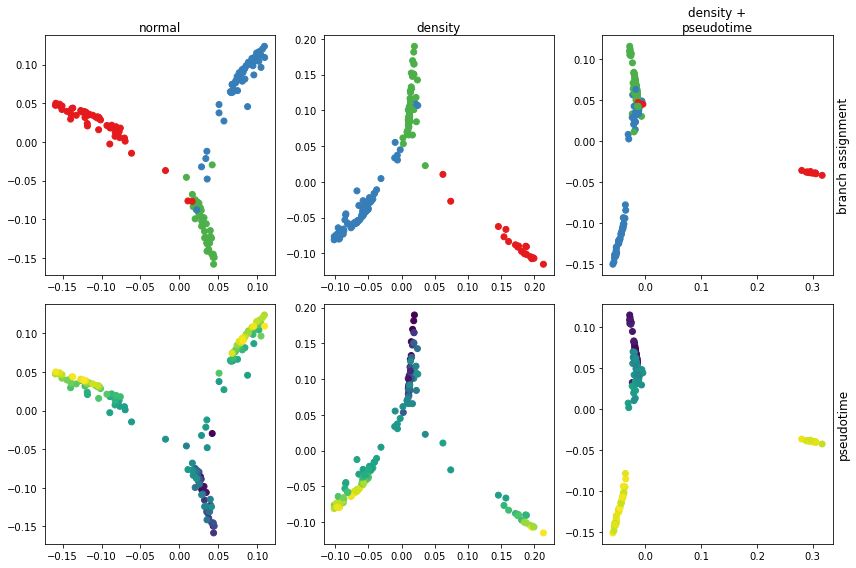

In [11]:
mpl.rcParams['image.cmap'] = 'viridis'
cmap = plt.cm.get_cmap("Set1")

fig, ax = plt.subplots(ncols=3, nrows=2)
fig.set_size_inches(w=12, h=8)
ax[0][0].scatter(dm1[:, 1], dm1[:, 2], c=cmap(indices1))
ax[1][0].scatter(dm1[:, 1], dm1[:, 2], c=labs1)
ax[0][1].scatter(dm2[:, 1], dm2[:, 2], c=cmap(indices2))
ax[1][1].scatter(dm2[:, 1], dm2[:, 2], c=labs2)
ax[0][2].scatter(dm3[:, 1], dm3[:, 2], c=cmap(indices3))
ax[1][2].scatter(dm3[:, 1], dm3[:, 2], c=labs3)

ax[0][2].yaxis.set_label_position("right")
ax[0][2].set_ylabel("branch assignment", rotation=90, size='large')
ax[1][2].yaxis.set_label_position("right")
ax[1][2].set_ylabel("pseudotime", rotation=90, size='large')

ax[0][0].xaxis.set_label_position("top")
ax[0][0].set_xlabel("normal", size='large')
ax[0][1].xaxis.set_label_position("top")
ax[0][1].set_xlabel("density", size='large')
ax[0][2].xaxis.set_label_position("top")
ax[0][2].set_xlabel("density +\npseudotime", size='large')

fig.tight_layout()

plt.show()